# Assess the Output of a Saved Model

This notebook allows you to load the weights of a trained U-Net model, pass data to it, and turn the model's output back in to audio, for subjective assesment against the original mixed and isolated signals.

In [2]:
#  Import a bunch of stuff
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.cmap'] = 'hot'
import IPython.display as ipd
import tensorflow as tf
import mir_eval

import audio_functions as af
import audio_models
import dataset

In [26]:
import importlib
importlib.reload(af)

<module 'audio_functions' from 'C:\\Users\\Toby\\MSc_Project\\MScFinalProject\\audio_functions.py'>

### Get the variables and data ready

In [27]:
#  Set variables
sample_rate=16384
n_fft=1024
fft_hop=256
patch_window=256
patch_hop=128
n_parallel_readers=4
normalise=True
batch_size = 5
shuffle=False
n_shuffle = 1
learning_rate = 0.0002

#checkpoint = '52/52-10' #  Best U-net
checkpoint = '136/136-6'
#model_base_dir = '/home/enterprise.internal.city.ac.uk/acvn728/checkpoints'
model_base_dir = 'C:/Users/Toby/MSc_Project/MScFinalProjectCheckpoints'

#directory_a = 'C:/Users/Toby/MSc_Project/Test_Audio/CHiME/test/Mixed'
#directory_b = 'C:/Users/Toby/MSc_Project/Test_Audio/CHiME/test/Voice'

directory_a = 'C:/Users/Toby/Speech_Data/LibriSpeechMini/Mixed/train-clean-100/19/198/'
directory_b = 'C:/Users/Toby/Speech_Data/LibriSpeechMini/Voice/train-clean-100/19/198/'

#directory_a = '/home/enterprise.internal.city.ac.uk/acvn728/LibriSpeechMini/Mixed/train-clean-100/19/198/'
#directory_b = '/home/enterprise.internal.city.ac.uk/acvn728/LibriSpeechMini/Voice/train-clean-100/19/198/'

#directory_a = '/data/Speech_Data/LibriSpeech/Mixed/test-clean/1580/141083/'
#directory_b = '/data/Speech_Data/LibriSpeech/Voice/test-clean/1580/141083/'


#  Create the pipeline
tf.reset_default_graph()
data = dataset.zip_files(directory_a, directory_b)
data = dataset.get_paired_dataset(data,
                                  sample_rate,
                                  n_fft,
                                  fft_hop,
                                  patch_window,
                                  patch_hop,
                                  n_parallel_readers,
                                  batch_size,
                                  n_shuffle,
                                  normalise)

#  Create the iterator
mixed_spec, voice_spec, mixed_audio, voice_audio = data.make_one_shot_iterator().get_next()

#  Create variable placeholders
is_training = tf.placeholder(shape=(), dtype=bool)
mixed_mag = tf.expand_dims(mixed_spec[:, :, :-1, 2], 3)
mixed_phase = tf.expand_dims(mixed_spec[:, :, :-1, 3], 3)
voice_mag = tf.expand_dims(voice_spec[:, :, :-1, 2], 3)

data

<PrefetchDataset shapes: ((?, 256, 513, 4), (?, 256, 513, 4), (?, 65280, 1), (?, 65280, 1)), types: (tf.float32, tf.float32, tf.float32, tf.float32)>

### Define the model structure

In [28]:
# Build U-Net model
print('Creating model')
model = audio_models.MagnitudeModel(mixed_mag, voice_mag, mixed_phase, mixed_audio, 
                                    voice_audio, 'unet', is_training, learning_rate, 'mag', name='Magnitude_Model')
tf_config = tf.ConfigProto()
tf_config.gpu_options.allow_growth = True
tf_config.gpu_options.visible_device_list = str(0)
sess = tf.Session(config=tf_config)
sess.run(tf.global_variables_initializer())

Creating model


### Load the saved weights - Skip this cell to hear results from a randomly initialised network

In [29]:

print('Loading checkpoint')
checkpoint_path = os.path.join(model_base_dir, checkpoint)
restorer = tf.train.Saver()
restorer.restore(sess, checkpoint_path)

Loading checkpoint
INFO:tensorflow:Restoring parameters from C:/Users/Toby/MSc_Project/MScFinalProjectCheckpoints\136/136-6


### Run a batch

In [30]:
mix_mag, mix_phase, voice_mag, voice_est_mag, mask, voice_wave, mix_wave = sess.run([model.mixed_input, 
                                                                                     model.mixed_phase, 
                                                                                     model.voice_input,
                                                                                     model.gen_voice, 
                                                                                     model.voice_mask, 
                                                                                     model.voice_audio, 
                                                                                     model.mixed_audio],
                                                                                    {model.is_training:False})
voice_est_wave = np.empty(voice_wave.shape)

for i in range(voice_mag.shape[0]):
    wave = af.spectrogramToAudioFile(np.squeeze(voice_est_mag[i, :, :, :]).T, n_fft,
                                     fft_hop, phaseIterations=0, phase=np.squeeze(mix_phase[i, :, :, :]).T)
    voice_est_wave[i,:,:] = np.expand_dims(wave, axis=1)


### Visualise and Listen to the output

The output will consist of up to [batch_size] clips from a single recording.

In [31]:
i=1
x = range(len(voice_est_wave[i]))
print(len(voice_est_wave))
print(len(voice_est_wave[0]))

5
65280


In [32]:
# Infer the background noise and background noise estimate by subtracting the voice and voice estimate from the mixture
# Normalise audio prior to subtraction
def normalise_audio(audio):
    norm_audio = 2*((audio - audio.min())/(audio.max()-audio.min())) - 1
    return norm_audio

for i in range (voice_wave.shape[0]):
    voice_wave[i,:,:] = normalise_audio(voice_wave[i,:,:])
    voice_est_wave[i,:,:] = normalise_audio(voice_est_wave[i,:,:])
    mix_wave[i,:,:] = normalise_audio(mix_wave[i,:,:])

bg_ref_wave = mix_wave - voice_wave
bg_est_wave = mix_wave - voice_est_wave

In [33]:
# Calculate audio metrics for the batch
ref_sources = []
est_sources = []
mixed_sources = []
sdrs = np.empty((0, 2))
sirs = np.empty((0, 2))
sars = np.empty((0, 2))
nsdrs = np.empty((0, 2))
for i in range(len(voice_est_wave)):
    ref_sources.append(np.concatenate((voice_wave[i], bg_ref_wave[i]), axis=1))
    est_sources.append(np.concatenate((voice_est_wave[i], bg_est_wave[i]), axis=1))
    mixed_sources.append(np.concatenate((mix_wave[i], mix_wave[i]), axis=1))
    sdr, sir, sar, _ = mir_eval.separation.bss_eval_sources(ref_sources[i].T, est_sources[i].T, compute_permutation=False)
    sdr_mr, _, _, _ = mir_eval.separation.bss_eval_sources(ref_sources[i].T, mixed_sources[i].T, compute_permutation=False)
    nsdr = sdr - sdr_mr
    sdrs = np.concatenate((sdrs, np.expand_dims(sdr, 1).T), axis=0)
    sirs = np.concatenate((sirs, np.expand_dims(sir, 1).T), axis=0)
    sars = np.concatenate((sars, np.expand_dims(sar, 1).T), axis=0)
    nsdrs = np.concatenate((nsdrs, np.expand_dims(nsdr, 1).T), axis=0)

print('Metrics (voice, background):\nSDR\n',
      sdrs, '\nSIR\n', sirs, '\nSAR\n', sars, '\nNSDR\n', nsdrs)

C:\Program Files\Anaconda3\lib\site-packages\scipy\fftpack\basic.py:159: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


Metrics (voice, background):
SDR
 [[17.14140771  9.75504715]
 [16.60090274  4.65079284]
 [16.44273784  6.69769217]
 [19.78815094  5.89214632]
 [10.48062536  2.79292348]] 
SIR
 [[21.66246205 15.92425681]
 [21.74790267 11.84045889]
 [24.05044947 13.92713641]
 [26.42303653 12.03902339]
 [19.08973882  7.16314753]] 
SAR
 [[19.06253527 11.06562099]
 [18.21439436  5.84666575]
 [17.28721734  7.78122376]
 [20.86056185  7.3636617 ]
 [11.17751736  5.53250831]] 
NSDR
 [[ 8.33444466 13.45779734]
 [ 4.73653099 16.56455841]
 [ 6.68265545 16.49661818]
 [ 7.21294389 10.90138751]
 [ 5.78543064  7.43176992]]


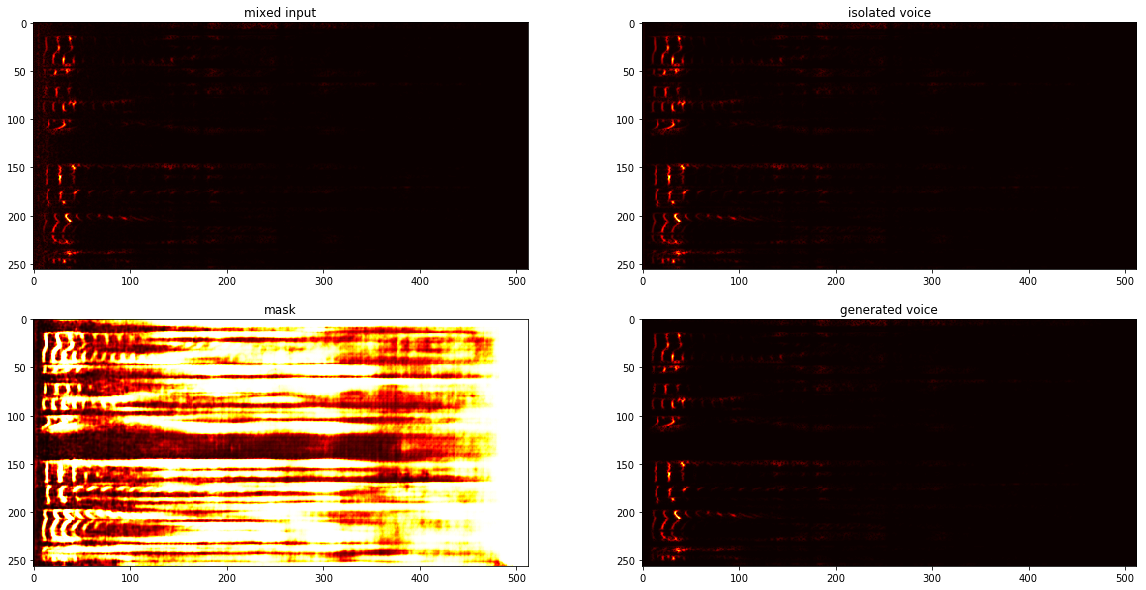

In [34]:
i=1

fig, ax = plt.subplots(2,2, figsize=(20,10))

ax[0,0].imshow(mix_mag[i,:,:,0])
ax[0,0].set_title('mixed input')
ax[0,1].imshow(voice_mag[i,:,:,0])
ax[0,1].set_title('isolated voice')
ax[1,0].imshow(mask[i,:,:,0])
ax[1,0].set_title('mask')
ax[1,1].imshow(voice_est_mag[i,:,:,0])
ax[1,1].set_title('generated voice')
plt.show()

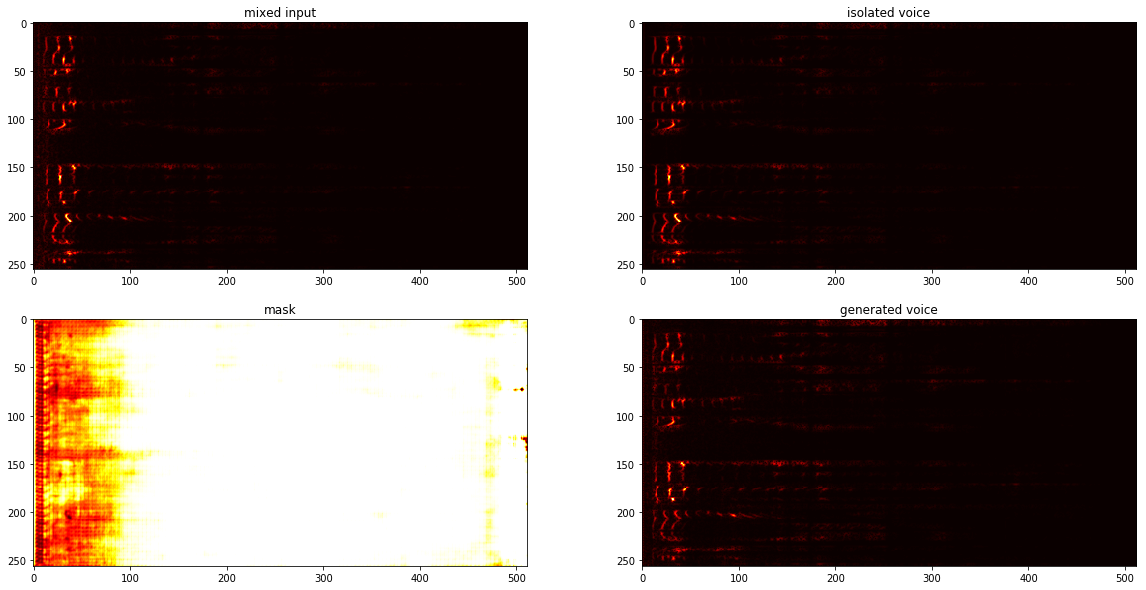

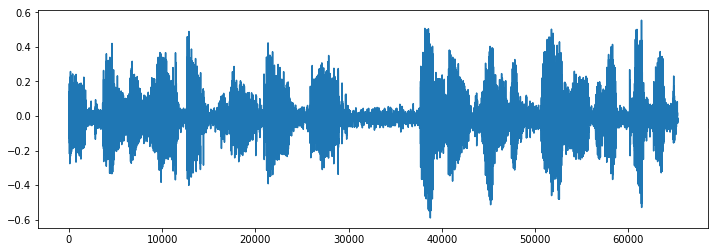

In [49]:
#  The original mixture
plt.figure(figsize=(12,4))
plt.plot(x,mix_wave[i])
ipd.Audio(mix_wave[i].T, rate=sample_rate)

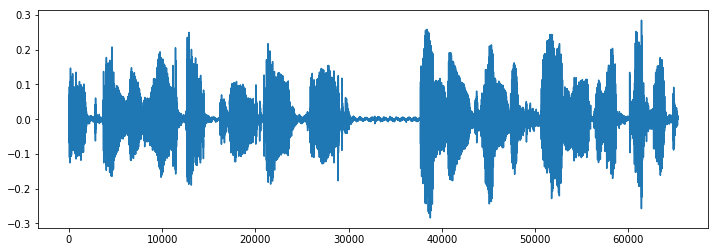

In [50]:
#  The original isolated voice
plt.figure(figsize=(12,4))
plt.plot(x,voice_wave[i])
ipd.Audio(voice_wave[i].T, rate=sample_rate)

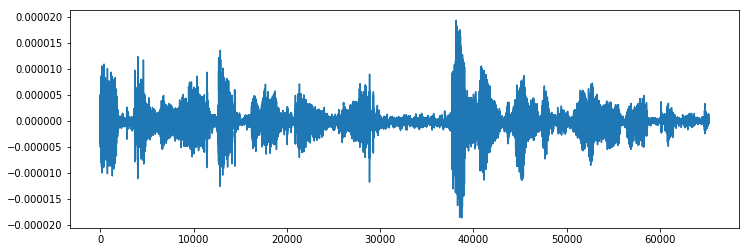

In [51]:
#  The estimated isolated voice produced by the network
plt.figure(figsize=(12,4))
plt.plot(x,voice_est_wave[i])
ipd.Audio(voice_est_wave[i].T, rate=sample_rate)

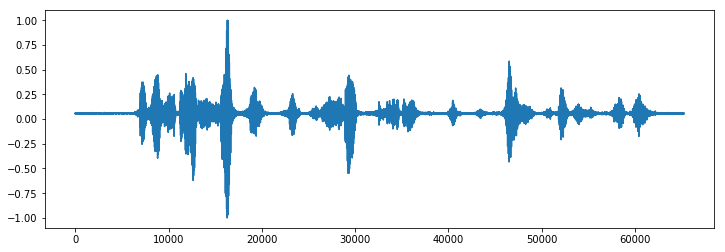

In [26]:
#  The estimated isolated voice produced by the network
plt.figure(figsize=(12,4))
plt.plot(x,voice_est_wave[i])
ipd.Audio(voice_est_wave[i].T, rate=sample_rate)

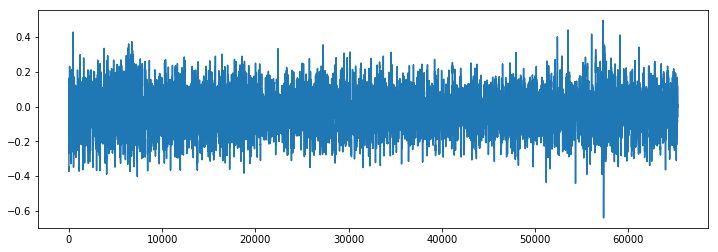

In [15]:
#  The background noise, by subtracting the voice on the waveform - doesn't seem to work
#print(metrics['mix'])
plt.figure(figsize=(12,4))
plt.plot(x,bg_ref_wave[i])
ipd.Audio(bg_ref_wave[i].T, rate=sample_rate)

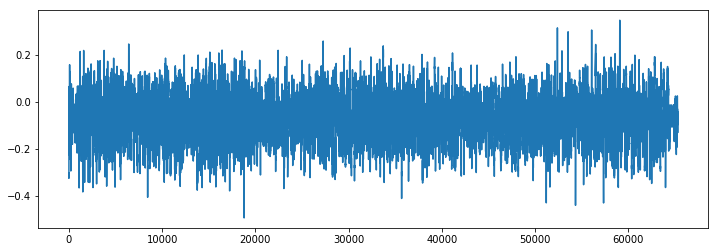

In [16]:
#  The background noise, by subtracting magnitude spectrograms
plt.figure(figsize=(12,4))
plt.plot(x,bg_est_wave[i])
ipd.Audio(bg_est_wave[i].T, rate=sample_rate)

## Reconstruction Investigations

#### Background Noise Estimation

In [194]:
i=4

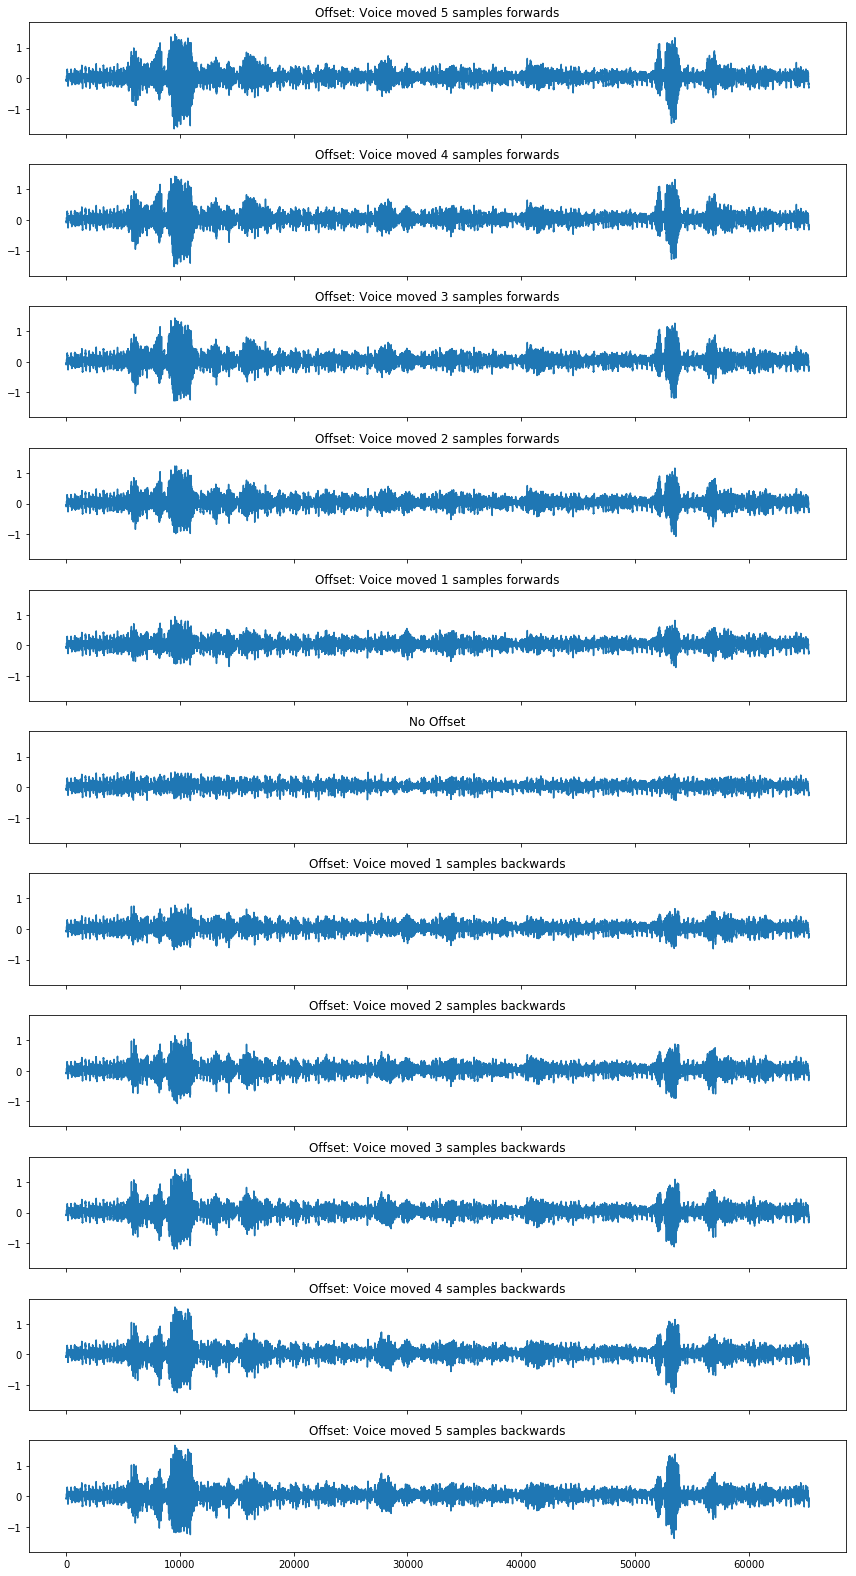

In [130]:
fig, ax = plt.subplots(11,1, figsize=(12,22), sharey=True, sharex=True)
j=0

for k in reversed(range(1, 6)):
    x =range(len(voice_wave[i][k:]))
    ax[j].plot(x,(mix_wave[i][:-k]-voice_wave[i][k:]))
    ax[j].set_title('Offset: Voice moved {} samples forwards'.format(k))
    #ipd.Audio((mix_wave[i][k:]-voice_wave[i][:-k]).T, rate=sample_rate)
    j+=1
x =range(len(mix_wave[i]))
ax[j].plot(x,(mix_wave[i]-voice_wave[i]))
ax[j].set_title('No Offset')
j+=1
for k in range(1, 6):
    x =range(len(mix_wave[i][k:]))
    ax[j].plot(x,(mix_wave[i][k:]-voice_wave[i][:-k]))
    ax[j].set_title('Offset: Voice moved {} samples backwards'.format(k))
    #ipd.Audio((mix_wave[i][k:]-voice_wave[i][:-k]).T, rate=sample_rate)
    j+=1
plt.tight_layout()

#### Time Offset

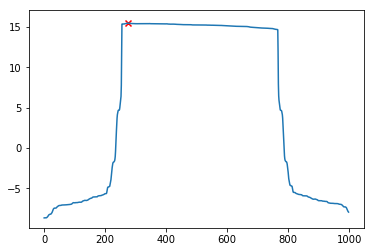

In [340]:
x = range(len(sdrs))
max_idx = sdrs.index(max(sdrs))
plt.plot(x,sdrs)
plt.scatter(max_idx,sdrs[max_idx], c='r', marker = 'x')

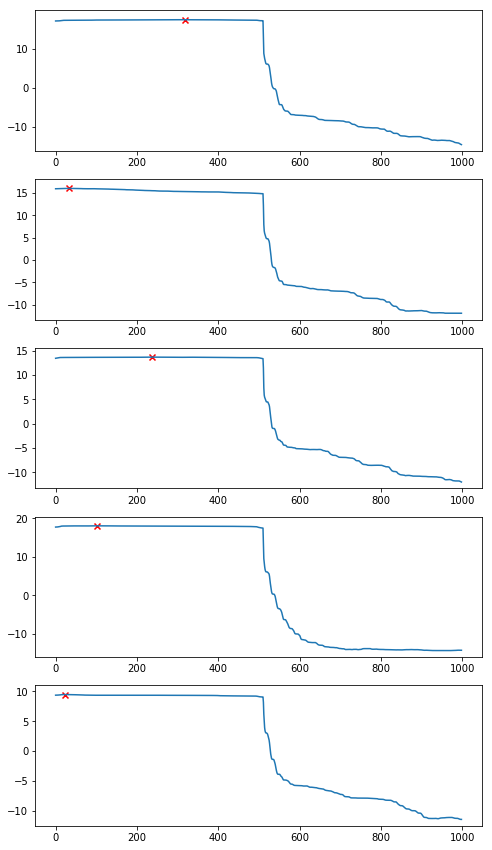

In [29]:
fig, ax = plt.subplots(5,1, figsize=(8,15))
for i in range(len(sdrs)):
    x = range(len(sdrs[i]))
    max_idx = sdrs[i].index(max(sdrs[i]))
    ax[i].plot(x,sdrs[i])
    ax[i].scatter(max_idx,sdrs[i][max_idx], c='r', marker = 'x')

In [23]:
try:
    mix, voice, mask, gen_voice, conv,\
       pc, seg = sess.run([model.mixed_mag, model.voice_mag, model.voice_mask, model.gen_voice, model.voice_mask_network.conv1,
                           model.voice_mask_network.primary_caps, model.voice_mask_network.seg_caps])
except tf.errors.OutOfRangeError:
    sess.run(pipe.initializer)

Text(0.5, 1.0, 'Seg Cap')

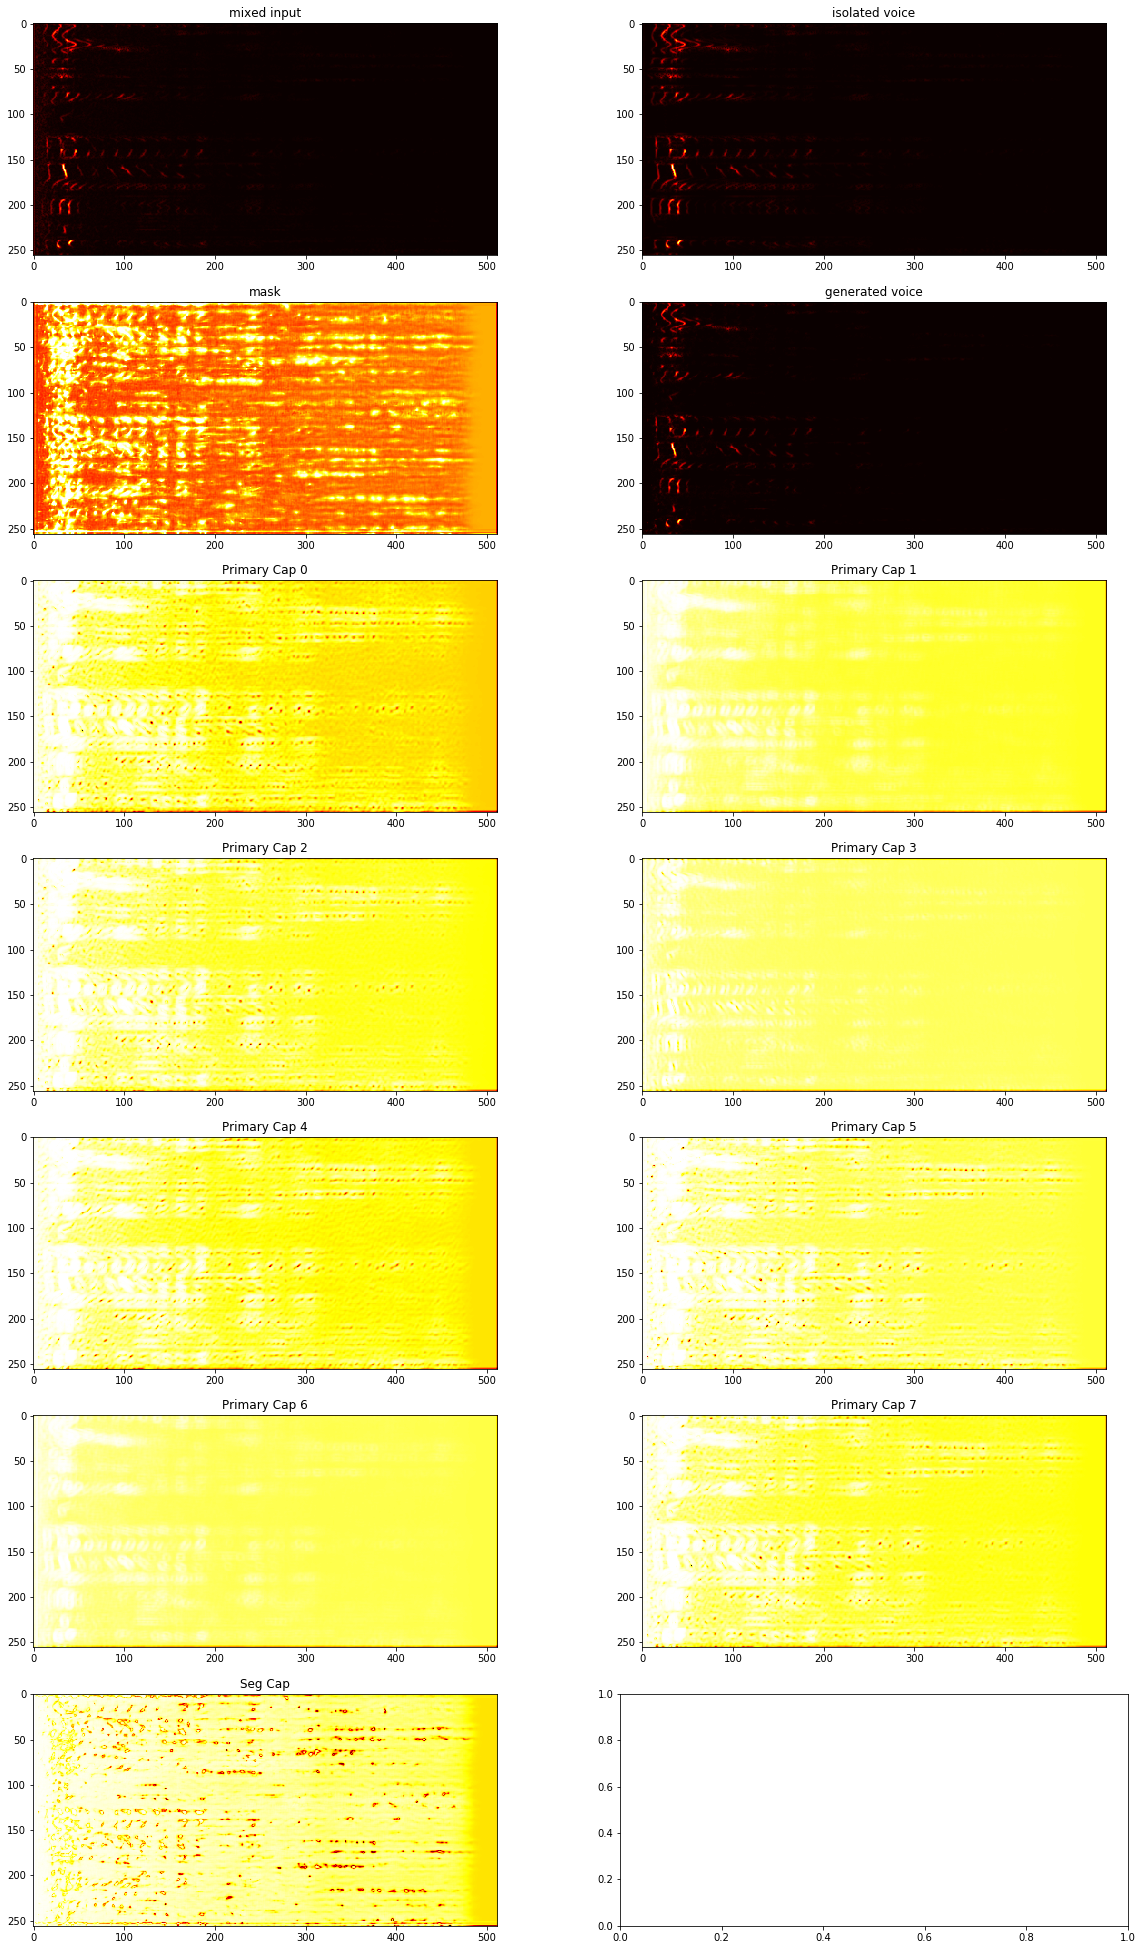

In [24]:
fig, ax = plt.subplots(7,2, figsize=(20,35))
i=1

ax[0,0].imshow(mix[i,:,:,0])
ax[0,0].set_title('mixed input')
ax[0,1].imshow(voice[i,:,:,0])
ax[0,1].set_title('isolated voice')
ax[1,0].imshow(mask[i,:,:,0])
ax[1,0].set_title('mask')
ax[1,1].imshow(gen_voice[i,:,:,0])
ax[1,1].set_title('generated voice')
ax[2,0].imshow(np.linalg.norm(pc, axis=4)[i, :, :, 0])
ax[2,0].set_title('Primary Cap 0')
ax[2,1].imshow(np.linalg.norm(pc, axis=4)[i, :, :, 1])
ax[2,1].set_title('Primary Cap 1')
ax[3,0].imshow(np.linalg.norm(pc, axis=4)[i, :, :, 2])
ax[3,0].set_title('Primary Cap 2')
ax[3,1].imshow(np.linalg.norm(pc, axis=4)[i, :, :, 3])
ax[3,1].set_title('Primary Cap 3')
ax[4,0].imshow(np.linalg.norm(pc, axis=4)[i, :, :, 4])
ax[4,0].set_title('Primary Cap 4')
ax[4,1].imshow(np.linalg.norm(pc, axis=4)[i, :, :, 5])
ax[4,1].set_title('Primary Cap 5')
ax[5,0].imshow(np.linalg.norm(pc, axis=4)[i, :, :, 6])
ax[5,0].set_title('Primary Cap 6')
ax[5,1].imshow(np.linalg.norm(pc, axis=4)[i, :, :, 7])
ax[5,1].set_title('Primary Cap 7')
ax[6,0].imshow(np.linalg.norm(seg, axis=4)[i, :, :, 0])
ax[6,0].set_title('Seg Cap')

In [5]:
tf.trainable_variables()

[<tf.Variable 'Magnitude_Model/SegCaps_CapsNetBasic/Convolution/conv2d/kernel:0' shape=(5, 5, 1, 128) dtype=float32_ref>,
 <tf.Variable 'Magnitude_Model/SegCaps_CapsNetBasic/Convolution/conv2d/bias:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'Magnitude_Model/SegCaps_CapsNetBasic/Primary_Caps/primarycaps/W:0' shape=(5, 5, 128, 64) dtype=float32_ref>,
 <tf.Variable 'Magnitude_Model/SegCaps_CapsNetBasic/Primary_Caps/primarycaps/b:0' shape=(1, 1, 8, 8) dtype=float32_ref>,
 <tf.Variable 'Magnitude_Model/SegCaps_CapsNetBasic/Seg_Caps/seg_caps/W:0' shape=(1, 1, 8, 8) dtype=float32_ref>,
 <tf.Variable 'Magnitude_Model/SegCaps_CapsNetBasic/Seg_Caps/seg_caps/b:0' shape=(1, 1, 1, 8) dtype=float32_ref>,
 <tf.Variable 'Magnitude_Model/SegCaps_CapsNetBasic/Reconstruction/reconstruction/W:0' shape=(1, 1, 8, 1) dtype=float32_ref>,
 <tf.Variable 'Magnitude_Model/SegCaps_CapsNetBasic/Reconstruction/reconstruction/b:0' shape=(1, 1, 1, 1) dtype=float32_ref>]

In [18]:
print(conv.shape)
print(pc.shape)
print(seg.shape)

(5, 256, 512, 1, 128)
(5, 256, 512, 8, 8)
(5, 256, 512, 1, 8)


In [11]:
pc_w = sess.run('Magnitude_Model/SegCaps_CapsNetBasic/Primary_Caps/primarycaps/W:0')
seg_w = sess.run('Magnitude_Model/SegCaps_CapsNetBasic/Seg_Caps/seg_caps/W:0')

In [22]:
print(pc_w.shape)
print(seg_w.shape)

(5, 5, 128, 64)
(1, 1, 8, 8)


In [19]:
pc_hat = pc[0,:,:,:,:] * seg_w

In [20]:
pc_hat.shape

(256, 512, 8, 8)

In [21]:
conv_hat = conv[0,:,:,:,:] * pc_w

ValueError: operands could not be broadcast together with shapes (256,512,1,128) (5,5,128,64) 

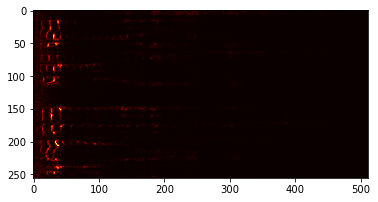

In [17]:
plt.imshow(mix_mag[i,:,:,0])